In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Funciones para crear los datos y para dibujar

In [2]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados

    return X_rotados

In [3]:
def genera_puntos_gausiana2D(Npuntos, media, var1, var2, angulo, display):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * np.sqrt(var1) # se multiplica cada atributo por la
    X[1,:] = X[1,:] * np.sqrt(var2) # raiz cuadrada de la varianza deseada

    X = rota_datos_alrededor_origen(X, angulo)

    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]

    # Display
    if display:
        plt.figure(1)
        plt.plot(X[0,:],X[1,:],'bo',zorder=1)
        plt.grid(True)
        plt.axis('equal')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    return X

## Generación de los datos del problema:

In [4]:
# Number of samples per component:
n_samples = 200

# Generate random sample, three components:
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 1, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [10, 0], 8, 1, 45, False)
X3 = genera_puntos_gausiana2D(n_samples, [5, 5], 4, 1, 0, False)
X = np.concatenate((X1, X2, X3), axis=1).transpose()
Y = np.array([0] * n_samples + [1] * n_samples + [2] * n_samples)

print(X.shape, Y.shape)

(600, 2) (600,)


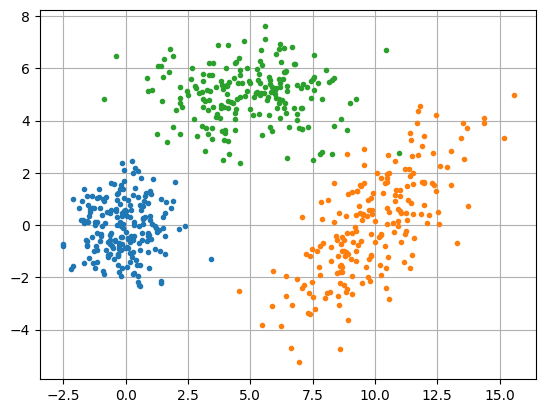

In [5]:
plt.figure()
for c in np.unique(Y):
  plt.plot(X[Y==c, 0], X[Y==c, 1], '.')
plt.grid(True)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Entrenamiento con Logistic Regression Multiclase

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9916666666666667

In [8]:
xx, yy = np.meshgrid(np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.1), np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.1))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

p = lr.predict_proba(xy)

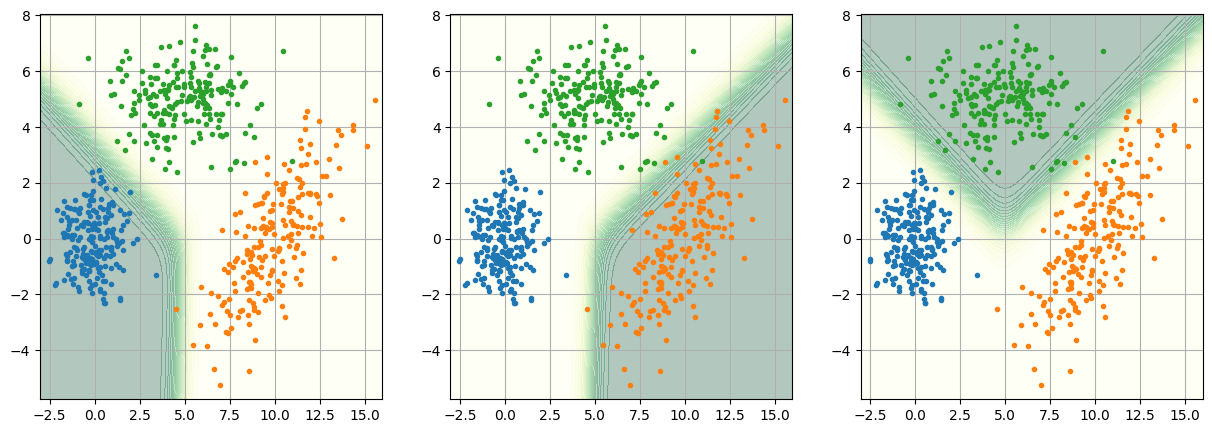

In [9]:
plt.figure(figsize=(15, 5))
for c in np.unique(Y):
  zz = p[:, c].reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.show()

**¿Qué está pasando?**

¿Cómo hemos podido ejecutar una regresión logística para un problema de 3 clases?

Internamente, si no le decimos nada, LogisticRegression de SKlearn utiliza la estrategia 'multinomial'. Esta estrategia es exactamente equivalente a utilizar una red neuronal sin capas ocultas y 3 salidas (una por cada clase). Como esto lo veremos más adelante con redes neuronales, **no lo explicaremos en detalle aún**. Sin embargo, aquí tenéis el código para comprobar qué es exactamente lo que está haciendo.

In [10]:
lr.predict_proba(X_train)

array([[9.97663241e-01, 1.23068708e-05, 2.32445165e-03],
       [9.99919111e-01, 2.02094530e-07, 8.06873703e-05],
       [6.20510250e-06, 9.95269734e-01, 4.72406130e-03],
       ...,
       [6.21980751e-05, 9.44402613e-01, 5.55351886e-02],
       [2.10057481e-04, 1.02799234e-06, 9.99788915e-01],
       [9.99943456e-01, 1.48830835e-07, 5.63954862e-05]])

In [11]:
w = lr.coef_
b = lr.intercept_

z = lambda x: x @ w.T + b
softmax = lambda x: np.exp(z(x)) / np.exp(z(x)).sum(axis=1, keepdims=True)

softmax(X_train)

array([[9.97663241e-01, 1.23068708e-05, 2.32445165e-03],
       [9.99919111e-01, 2.02094530e-07, 8.06873703e-05],
       [6.20510250e-06, 9.95269734e-01, 4.72406130e-03],
       ...,
       [6.21980751e-05, 9.44402613e-01, 5.55351886e-02],
       [2.10057481e-04, 1.02799234e-06, 9.99788915e-01],
       [9.99943456e-01, 1.48830835e-07, 5.63954862e-05]])

In [12]:
# Utilizo isclose por errores de precisión
# lr.predict_proba(X_train) == softmax(X_train) tiene ligeros errores de precisión
np.isclose(lr.predict_proba(X_train), softmax(X_train)).all()

np.True_

Sin embargo, podemos utilizar una alternativa indicándoselo explícitamente: 'ovr' (**One vs Rest**). Esto significa que va a construir un modelo para separar cada una de las clases de forma individual.

In [13]:
lr = LogisticRegression(multi_class="ovr")
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.9916666666666667

In [14]:
xx, yy = np.meshgrid(np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.1), np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.1))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

p = lr.predict_proba(xy)

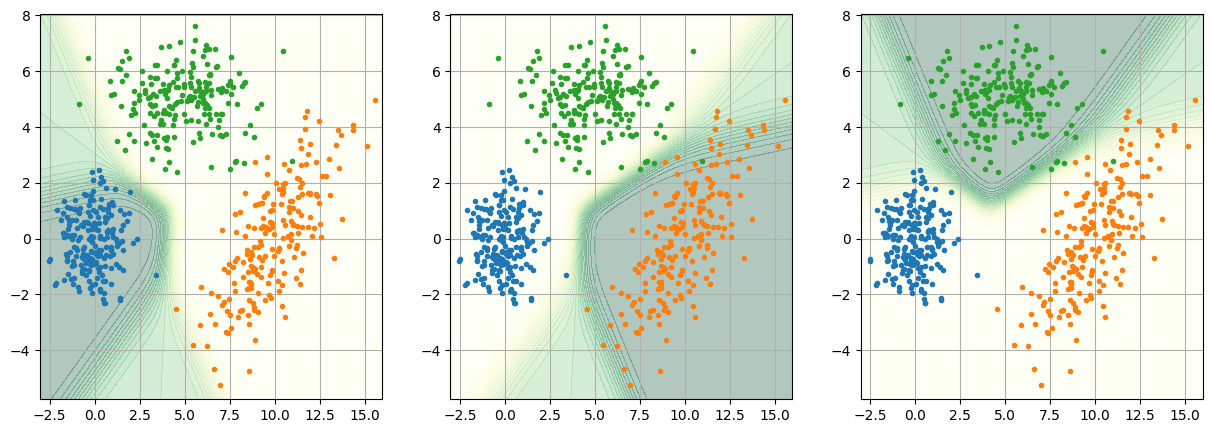

In [15]:
plt.figure(figsize=(15, 5))
for c in np.unique(Y):
  zz = p[:, c].reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.show()

En realidad, tenemos un separador lineal para cada clase. Vamos a verlos individualmente.

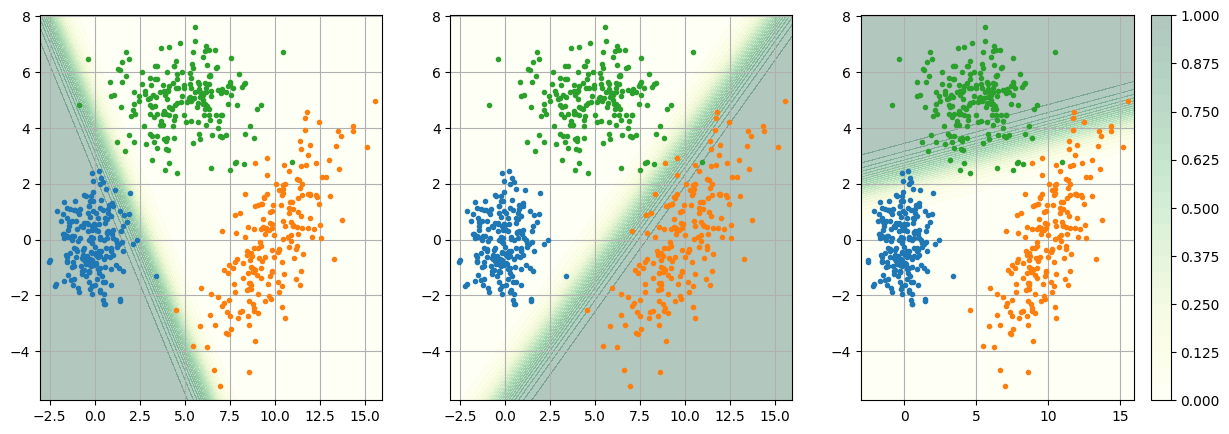

In [16]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))


plt.figure(figsize=(15, 5))
for c in np.unique(y_train):
  w = lr.coef_[c]
  b = lr.intercept_[c]
  model = lambda x: sigmoid(x @ w + b) # Este es mi modelo individual one-vs-rest

  p = model(xy)
  zz = p.reshape(xx.shape)
  levels = np.linspace(0, zz.max(), 25)

  plt.subplot(1,3,c+1)
  plt.contourf(xx, yy, zz, levels=levels, cmap="YlGn", alpha=0.3)
  for cl in np.unique(Y):
    plt.plot(X[Y==cl, 0], X[Y==cl, 1], '.')

  plt.grid()
plt.colorbar()
plt.show()

Vamos a comprobar si es exactamente lo que está haciendo este modelo de LogisticRegression 'ovr':

In [17]:
lr.predict_proba(X_train)

array([[9.97770279e-01, 7.07822331e-04, 1.52189820e-03],
       [9.99246869e-01, 2.25123759e-04, 5.28006752e-04],
       [6.73903116e-07, 9.99651842e-01, 3.47483945e-04],
       ...,
       [1.75856037e-06, 9.97521173e-01, 2.47706861e-03],
       [1.74100892e-04, 2.09105767e-06, 9.99823808e-01],
       [9.99343995e-01, 2.25008995e-04, 4.30996092e-04]])

In [18]:
preds = np.zeros((len(X_train), 3))

for c in np.unique(y_train):
  w = lr.coef_[c]
  b = lr.intercept_[c]
  model = lambda x: sigmoid(x @ w + b)
  p = model(X_train)
  preds[:, c] = p

In [19]:
# Si imprimimos preds tal cual, vemos que no son iguales
preds

array([[9.81313421e-01, 6.96147769e-04, 1.49679657e-03],
       [9.99651970e-01, 2.25215026e-04, 5.28220808e-04],
       [6.62463375e-07, 9.82682402e-01, 3.41585284e-04],
       ...,
       [1.50776127e-06, 8.55258549e-01, 2.12379864e-03],
       [1.73784571e-04, 2.08725847e-06, 9.98007248e-01],
       [9.99760519e-01, 2.25102778e-04, 4.31175730e-04]])

**¿Por qué?** Porque estamos dando la probabilidad de pertenecer a cada clase de forma independiente. Lo que nos queda por hacer es normalizar las probabilidades para que sumen 1.

In [20]:
preds = preds / preds.sum(axis=1, keepdims=True)

# Ahora sí, coinciden
preds

array([[9.97770279e-01, 7.07822331e-04, 1.52189820e-03],
       [9.99246869e-01, 2.25123759e-04, 5.28006752e-04],
       [6.73903116e-07, 9.99651842e-01, 3.47483945e-04],
       ...,
       [1.75856037e-06, 9.97521173e-01, 2.47706861e-03],
       [1.74100892e-04, 2.09105767e-06, 9.99823808e-01],
       [9.99343995e-01, 2.25008995e-04, 4.30996092e-04]])

In [21]:
np.isclose(preds, lr.predict_proba(X_train)).all()

np.True_